In [1]:
pip install scikit-learn xgboost joblib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib  # This is for saving our final models

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

print("Modeling libraries imported successfully.")

Modeling libraries imported successfully.


In [3]:
# The data is in the SAME folder, so the path is simple
df = pd.read_csv('processed_dataset.csv', index_col='timestamp', parse_dates=True)

print("Processed data loaded:")
df.head()

Processed data loaded:


,solar_output,wind_output,solar_irradiance,wind_speed,temperature,humidity,pressure,load_demand,grid_frequency,grid_voltage,...,hour,day_of_week,month,day_of_year,load_demand_lag1,solar_irradiance_lag1,wind_speed_lag1,wind_speed_roll_3h,solar_irradiance_roll_3h,load_roll_3h
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-01-01 02:00:00,73.199394,30.241951,485.378535,14.296742,12.945826,26.234179,970.753013,347.363574,49.575119,222.854681,...,2,6,1,1,185.824084,301.682091,6.638605,13.235210,512.828028,275.862969
2023-01-01 03:00:00,59.865848,56.340836,673.986395,22.357572,38.478603,53.165238,970.833286,193.641771,49.549129,227.861872,...,3,6,1,1,347.363574,485.378535,14.296742,14.430973,487.015674,242.276476
2023-01-01 04:00:00,15.601864,80.380489,868.457364,11.879943,4.807723,69.228330,977.621817,244.023572,49.444763,221.981539,...,4,6,1,1,193.641771,673.986395,22.357572,16.178086,675.940765,261.676306
2023-01-01 05:00:00,15.599452,13.714849,234.928743,23.627938,21.366223,48.943580,1021.172159,73.562168,49.665057,239.149290,...,5,6,1,1,244.023572,868.457364,11.879943,19.288484,592.457501,170.409170
2023-01-01 06:00:00,5.808361,58.069908,389.306505,5.361456,11.003133,71.150260,1010.626606,496.642132,49.706266,220.950784,...,6,6,1,1,73.562168,234.928743,23.627938,13.623112,497.564204,271.409291


In [4]:
# Our 3 targets to predict
TARGETS = ['solar_output', 'wind_output', 'load_demand']

# Our features (X) are ALL columns that are NOT targets
FEATURES = [col for col in df.columns if col not in TARGETS]

print(f"We will predict these {len(TARGETS)} targets: {TARGETS}")
print(f"Using these {len(FEATURES)} features: {FEATURES}")

We will predict these 3 targets: ['solar_output', 'wind_output', 'load_demand']
Using these 21 features: ['solar_irradiance', 'wind_speed', 'temperature', 'humidity', 'pressure', 'grid_frequency', 'grid_voltage', 'grid_exchange', 'battery_soc', 'battery_charge', 'battery_discharge', 'hour', 'day_of_week', 'month', 'day_of_year', 'load_demand_lag1', 'solar_irradiance_lag1', 'wind_speed_lag1', 'wind_speed_roll_3h', 'solar_irradiance_roll_3h', 'load_roll_3h']


Total data: 3544 hours
Training data: 2835 hours
Testing data: 709 hours


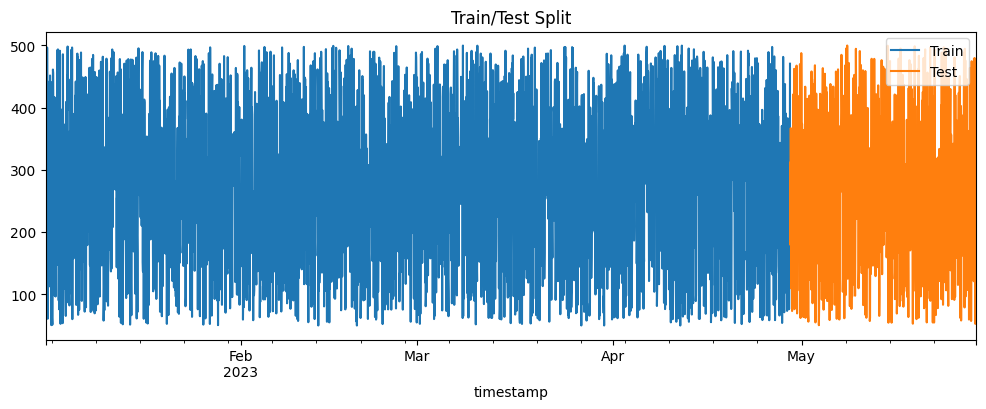

In [5]:
# We'll use 80% of the data to train, 20% to test
split_percentage = 0.8
split_index = int(len(df) * split_percentage)

# Split the data
df_train = df.iloc[:split_index]
df_test = df.iloc[split_index:]

print(f"Total data: {len(df)} hours")
print(f"Training data: {len(df_train)} hours")
print(f"Testing data: {len(df_test)} hours")

# Let's visualize the split on our 'load_demand' target
plt.figure(figsize=(12, 4))
df_train['load_demand'].plot(label='Train')
df_test['load_demand'].plot(label='Test')
plt.title('Train/Test Split')
plt.legend()

plt.savefig('train_test_split.png')
plt.show()

In [6]:
# Initialize the scaler
scaler = StandardScaler()

# 1. Scale Features (X)
# Fit and transform the training features
X_train_scaled = scaler.fit_transform(df_train[FEATURES])
# ONLY transform the test features (no 'fit'!)
X_test_scaled = scaler.transform(df_test[FEATURES])

# 2. Separate our Targets (y)
y_train = df_train[TARGETS]
y_test = df_test[TARGETS]

print("Data has been split and scaled.")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"y_train shape: {y_train.shape}")

Data has been split and scaled.
X_train_scaled shape: (2835, 21)
y_train shape: (2835, 3)


In [7]:
# 1. Define the models we want to try
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1, early_stopping_rounds=10)
}

# 2. Create places to store our results and trained models
all_results = {}
trained_models = {}

# 3. Loop through each target ('solar_output', 'wind_output', 'load_demand')
for target in TARGETS:
    print(f"=========================================")
    print(f" 🚀 Training Models for: {target}")
    print(f"=========================================")
    
    # Get the correct y data for this loop
    y_train_target = y_train[target]
    y_test_target = y_test[target]
    
    trained_models[target] = {}
    target_results = []
    
    # Now, loop through each model for this target
    for name, model in models.items():
        print(f"--- Training {name} ---")
        
        # XGBoost has a special feature to prevent overfitting
        if name == 'XGBoost':
            model.fit(X_train_scaled, y_train_target,
                      eval_set=[(X_test_scaled, y_test_target)],
                      verbose=False)
        else:
            model.fit(X_train_scaled, y_train_target)
            
        # Make predictions on the test set
        y_pred = model.predict(X_test_scaled)
        
        # Evaluate the model
        r2 = r2_score(y_test_target, y_pred)
        mae = mean_absolute_error(y_test_target, y_pred)
        
        print(f"✅ {name} complete. R2 Score: {r2:.4f}, MAE: {mae:.4f}")
        
        # Store results
        target_results.append({'Model': name, 'R2 Score': r2, 'MAE': mae})
        trained_models[target][name] = model # Save the trained model
        
    # Save the results table for this target
    all_results[target] = pd.DataFrame(target_results)
    print("\n")

print("🎉 All training complete!")

 🚀 Training Models for: solar_output
--- Training Linear Regression ---
✅ Linear Regression complete. R2 Score: -0.0147, MAE: 25.3561
--- Training Random Forest ---
✅ Random Forest complete. R2 Score: -0.0210, MAE: 25.4546
--- Training XGBoost ---
✅ XGBoost complete. R2 Score: -0.0128, MAE: 25.3557


 🚀 Training Models for: wind_output
--- Training Linear Regression ---
✅ Linear Regression complete. R2 Score: -0.0187, MAE: 25.1877
--- Training Random Forest ---
✅ Random Forest complete. R2 Score: -0.0265, MAE: 25.3068
--- Training XGBoost ---
✅ XGBoost complete. R2 Score: -0.0059, MAE: 25.0332


 🚀 Training Models for: load_demand
--- Training Linear Regression ---
✅ Linear Regression complete. R2 Score: 0.4727, MAE: 76.3324
--- Training Random Forest ---
✅ Random Forest complete. R2 Score: 0.4376, MAE: 79.2241
--- Training XGBoost ---
✅ XGBoost complete. R2 Score: 0.4358, MAE: 78.6200


🎉 All training complete!


In [8]:
print("--- ☀️ SOLAR OUTPUT RESULTS ---")
print(all_results['solar_output'])
print("\n")

print("--- 💨 WIND OUTPUT RESULTS ---")
print(all_results['wind_output'])
print("\n")

print("--- 💡 LOAD DEMAND RESULTS ---")
print(all_results['load_demand'])

--- ☀️ SOLAR OUTPUT RESULTS ---
               Model  R2 Score        MAE
0  Linear Regression -0.014685  25.356073
1      Random Forest -0.021016  25.454561
2            XGBoost -0.012779  25.355674


--- 💨 WIND OUTPUT RESULTS ---
               Model  R2 Score        MAE
0  Linear Regression -0.018661  25.187741
1      Random Forest -0.026461  25.306794
2            XGBoost -0.005936  25.033218


--- 💡 LOAD DEMAND RESULTS ---
               Model  R2 Score        MAE
0  Linear Regression  0.472726  76.332430
1      Random Forest  0.437641  79.224134
2            XGBoost  0.435837  78.619986


In [9]:
# We'll save our 3 best models (XGBoost)
joblib.dump(trained_models['solar_output']['XGBoost'], 'model_solar.joblib')
joblib.dump(trained_models['wind_output']['XGBoost'], 'model_wind.joblib')
joblib.dump(trained_models['load_demand']['XGBoost'], 'model_load.joblib')

# CRITICAL: We must also save the scaler. We need it to process new data.
joblib.dump(scaler, 'scaler.joblib')

print("All 3 models and the data scaler have been saved to .joblib files!")
print("We are now ready for Week 3.")

All 3 models and the data scaler have been saved to .joblib files!
We are now ready for Week 3.
